In [1]:
from signal_miner import *

import pandas as pd
import numpy as np
import random
from numerapi import NumerAPI
import lightgbm as lgb
import pickle
import os
from multiprocessing import Pool
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt

In [2]:
# Download and initialize data
napi = NumerAPI()
napi.download_dataset("v5.0/train.parquet", "v5.0/train.parquet")
napi.download_dataset("v5.0/validation.parquet", "v5.0/validation.parquet")

data = pd.concat([ pd.read_parquet("v5.0/train.parquet"), pd.read_parquet("v5.0/validation.parquet") ])

targets = [t for t in data.columns if 'target' in t]
feature_cols = [c for c in data.columns if 'feature' in c]

data['era'] = data['era'].astype('int')
data[targets] = (data[targets] * 4).astype('Int8')

eras = np.array(sorted(data['era'].unique()))

2025-01-28 15:24:30,551 INFO numerapi.utils: target file already exists
2025-01-28 15:24:30,551 INFO numerapi.utils: download complete
2025-01-28 15:24:31,076 INFO numerapi.utils: target file already exists
2025-01-28 15:24:31,077 INFO numerapi.utils: download complete


In [3]:
# Define the benchmark configuration
benchmark_cfg = {
    "colsample_bytree": 0.1,
    "max_bin": 5,
    "max_depth": 5,
    "num_leaves": 2**4-1,
    "min_child_samples": 20,
    "n_estimators": 2000,
    "reg_lambda": 0.0,
    "learning_rate": 0.01,
    "target": 'target'  # Use the first target for simplicity
}

# Parameter dictionary
param_dict = {
    'colsample_bytree': list(np.linspace(0.001, 1, 100)), 
    'reg_lambda': list(np.linspace(0, 100_000, 10000)),
    'learning_rate': list( np.linspace(.00001, 1.0, 1000, dtype='float') ),
    'max_bin' : list(np.linspace(2, 5, 4, dtype='int')),
    'max_depth': list(np.linspace(2, 12, 11, dtype='int')),# [5, 10, 15, 20, 25, 50, 100],
    'num_leaves': list(np.linspace(2, 24, 15, dtype='int')),#, 4112],#, 8192, 32768],
    'min_child_samples': list( np.linspace(1,250,250,dtype='int') ),
    'n_estimators': list( np.linspace(10,2000,1990,dtype='int') ),#,75,100,150,200],#, 500, 700, 900, 1200], 
    'target':targets,
}

# Cross-validation splits
ns = 2
all_splits = list(TimeSeriesSplit(n_splits=ns, max_train_size=100_000_000, gap=12).split(eras))

niter = 1000  # Small number for testing
configurations = get_rdn_cfgs(param_dict, niter)

# Add benchmark configuration as the first entry
configurations.insert(0, benchmark_cfg)

# Keep track of the benchmark ID (always 0 in this case)
BENCHMARK_ID = 0

# Prepare memory-mapped files
os.makedirs("results", exist_ok=True)
mmapped_array = np.memmap(
    os.path.join("results", "test_mmapped_array.dat"),
    dtype='float16', mode='w+', shape=(len(data), len(configurations))
)
done_splits = np.memmap(
    os.path.join("results", "test_done_splits.dat"),
    dtype='float16', mode='w+', shape=(len(all_splits) * len(configurations))
)
data['mmap_idx'] = range(len(data))

# Define the processing function
def process_split(task):
    train_didxs, test_didxs, k, cfg, split_id, split_num = task
    try:
        label = cfg['target']
        train_rows = (data['era'].isin(eras[train_didxs])) & (~data[label].isna())
        test_rows = (data['era'].isin(eras[test_didxs])) & (~data[label].isna())

        model = get_model(cfg)

        model.fit(
            data.loc[train_rows, feature_cols].values,
            data.loc[train_rows, label].values
        )

        result_vector = model.predict(data.loc[test_rows, feature_cols].values)
        mmapped_array[data.loc[test_rows, 'mmap_idx'].values, k] = result_vector
        done_splits[split_id] = 1
        done_splits.flush()
    except Exception as e:
        print(f"Error in process_split: {e}")

# Start mining
pool = Pool(processes=2)

def start_mining():
    split_data_list = []
    split_id = 0
    for k, cfg in enumerate(configurations):
        for i, (train_didxs, test_didxs) in enumerate(all_splits):
            task = (train_didxs, test_didxs, k, cfg, split_id, i)
            split_data_list.append(task)
            split_id += 1

    pool.imap(process_split, split_data_list, chunksize=1)

# Check progress
def check_progress():
    completed = np.sum(done_splits)
    total = len(done_splits)
    print(f"Progress: {completed}/{total} ({(completed / total) * 100:.2f}%)")

# End mining
def end_mining():
    global pool
    if pool is not None:
        pool.terminate()
        pool.close()
        pool.join()
        pool = None

# Example usage
start_mining()  # Start mining asynchronously
# check_progress()  # Check progress
# end_mining()  # Stop the pool when done

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.543680 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11880
[LightGBM] [Info] Number of data points in the train set: 1708483, number of used features: 2376
[LightGBM] [Info] Start training from score 2.000125
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 29.781438 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11880
[LightGBM] [Info] Number of data points in the train set: 3799413, number of used features: 2376
[LightGBM] [Info] Start training from score 2.000112
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 13.080211 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11880
[LightGBM] [Info] Number of data points in 

In [14]:
'''Check Progress Periodically'''
check_progress()

Progress: 4.0/2002 (0.20%)


In [9]:
'''
Get Dataframe of Results
'''
res_df = evaluate_completed_configs(data, configurations, mmapped_array, done_splits, all_splits, ns)
# Add a column to label benchmark configurations
res_df['is_benchmark'] = res_df.index == BENCHMARK_ID

In [10]:
print("Benchmark Results:")
res_df[res_df['is_benchmark']]

Benchmark Results:


,colsample_bytree,max_bin,max_depth,num_leaves,min_child_samples,n_estimators,reg_lambda,learning_rate,target,validation_corr,validation_shp,validation_max_dd,test_corr,test_shp,test_max_dd,whole_corr,whole_shp,whole_max_dd,is_benchmark
0,0.1,5,5,15,20,2000,0.0,0.01,target,0.032018,1.537099,0.088877,0.026162,1.212766,0.088877,0.032018,1.537099,0.088877,True


In [11]:
'''

Show All Models with Corr and Sharpe higher than benchmark on Entire Data Set

'''
print("Better Than Benchmark Results:")
compare_to_benchmark(res_df)

Better Than Benchmark Results:


,colsample_bytree,max_bin,max_depth,num_leaves,min_child_samples,n_estimators,reg_lambda,learning_rate,target,validation_corr,validation_shp,validation_max_dd,test_corr,test_shp,test_max_dd,whole_corr,whole_shp,whole_max_dd,is_benchmark


In [ ]:
'''
Visualize performance as a function of hyper params
'''

import matplotlib.pyplot as plt

''''show some eval metrics based on each hyperparam, also only see this if we want, should be packages in its own method'''
for col in res_df.select_dtypes(include= np.number).columns:
    plt.scatter(res_df[col], res_df['eval_shp'], label='test')
    plt.scatter(res_df[col], res_df['train_shp'], label='train')
    plt.xlabel(col)
    plt.legend()
    plt.show()

/tmp/ipykernel_32343/3426284711.py:21: RankWarning: Polyfit may be poorly conditioned
  m, b = np.polyfit(x, y, 1)  # Fit line: y = mx + b


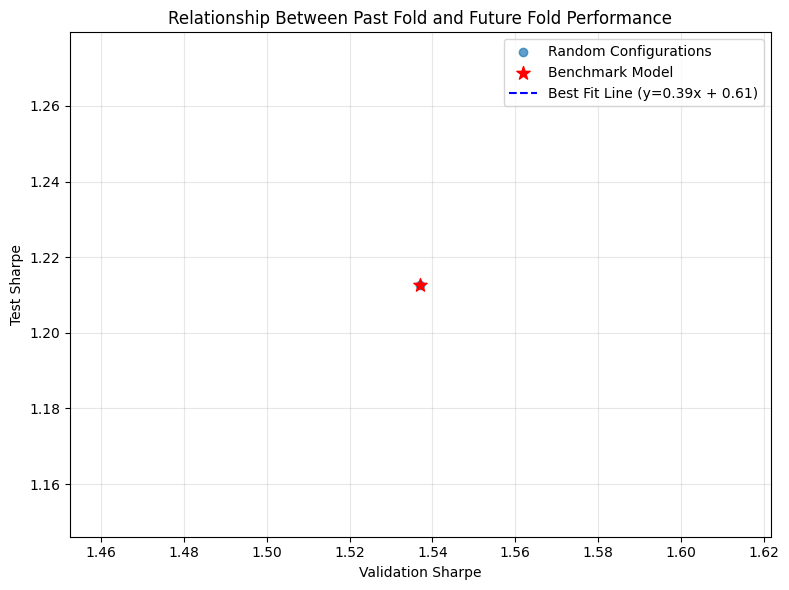

In [12]:
'''
IMPORTANT
Understand This Plot
Shows the relationship of past fold to future fold performance
'''
# Identify the benchmark configuration
benchmark_idx = BENCHMARK_ID
benchmark_validation_shp = res_df.loc[benchmark_idx, 'validation_shp']
benchmark_eval_shp = res_df.loc[benchmark_idx, 'test_shp']

# Scatter plot with enhancements
plt.figure(figsize=(8, 6))
plt.scatter(res_df['validation_shp'], res_df['test_shp'], alpha=0.7, label="Random Configurations")

# Highlight the benchmark model as a red star
plt.scatter(benchmark_validation_shp, benchmark_eval_shp, color='red', s=100, marker='*', label="Benchmark Model")

# Add a linear best-fit line
x = res_df['validation_shp']
y = res_df['test_shp']
m, b = np.polyfit(x, y, 1)  # Fit line: y = mx + b
plt.plot(x, m*x + b, color='blue', linestyle='--', label=f"Best Fit Line (y={m:.2f}x + {b:.2f})")

# Add labels, title, and legend
plt.xlabel("Validation Sharpe")
plt.ylabel("Test Sharpe")
plt.title("Relationship Between Past Fold and Future Fold Performance")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()

# Show the plot
plt.show()


In [16]:
to_export = [ res_df.sort_values('whole_shp').iloc[-1].name ] #can be a list to ensemble

In [21]:
evaluate_and_ensemble(to_export, configurations, mmapped_array, data, all_splits, feature_cols, get_model, save_name="model")

Selected ensemble: [2]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 14.907838 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7128
[LightGBM] [Info] Number of data points in the train set: 1947099, number of used features: 2376
[LightGBM] [Info] Start training from score 2.000123
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 28.011435 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7128
[LightGBM] [Info] Number of data points in the train set: 2746270, number of used features: 2376
[LightGBM] [Info] Start training from score 2.000107
Predict function saved as predict_model_full.pkl
